## Consuming data using Kafka and Visualise (20%) .  
In this task, we will implement an Apache Kafka consumer to consume the data from Part 2.  

Important:  
-	In this part, Kafka consumers are used to consume the streaming data published from task 2.8.  
-	This part doesn’t require parallel processing, and please do not use Spark in this part. It’s OK to use Pandas or any Python library to do simple calculations for the visualisation.  

In [1]:
import pandas as pd
import json
import datetime as dt
%matplotlib notebook

from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd


## 1.	(Basic plot) Plot a diagram with two subplots to show the following:  
a)	Left subplot: Show a bar chart of potential fraud count every 10 seconds(visualise data from 7a);  
b)	Right Subplot: Show a line chart of cumulative sales of top 20 products (non-fraud, sum of product*qty), update every 30 seconds. (visualise data from 7b) .  



<IPython.core.display.Javascript object>


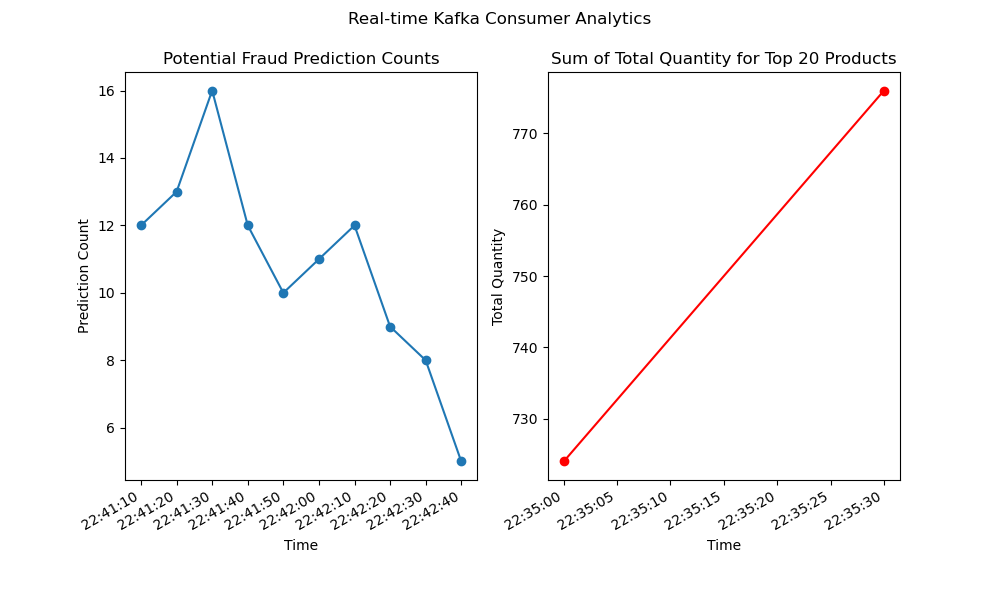

In [ ]:
hostip = "kafka" 
potential_fraud_topic = "potential_fraud_topic"
top_product_non_fraud_topic = "top_product_non_fraud_topic"

def connect_kafka_consumer():
    _consumer = None
    try:
        _consumer = KafkaConsumer(
            potential_fraud_topic,
            top_product_non_fraud_topic,
            bootstrap_servers=[f'{hostip}:9092'],
            api_version=(0, 10)
        )
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def initialize_charts():
    try:
        # Set dimensions for the figure
        chart_width = 10  # Renamed from 'width'
        chart_height = 6  # Renamed from 'height'

        # Create subplots
        figure, (axis_fraud, axis_quantity) = plt.subplots(1, 2, figsize=(chart_width, chart_height))  # Renamed axes
        figure.suptitle('Real-time Kafka Consumer Analytics') 

        # First subplot for Potential Fraud Prediction Counts
        axis_fraud.set_xlabel('Time')
        axis_fraud.set_ylabel('Prediction Count')
        axis_fraud.set_title('Potential Fraud Prediction Counts')

        # Second subplot for Total Quantity
        axis_quantity.set_xlabel('Time')
        axis_quantity.set_ylabel('Total Quantity')
        axis_quantity.set_title('Sum of Total Quantity for Top 20 Products')
        axis_quantity.set_ylim(4000, 4500)

        # Display the figure
        figure.show()
        figure.canvas.draw()
        figure.autofmt_xdate()

        return figure, axis_fraud, axis_quantity  # Updated return values
    except Exception as ex:
        print(str(ex))
        
def update_top_products(df):
    """
    Calculates the total quantity of the top 20 products and the latest window 
    from a Pandas DataFrame.

    Args:
        df: The Pandas DataFrame with columns 'windows.start', 'product_id', 
           and 'total_quantity'.

    Returns:
        A tuple containing the latest window and the total quantity of the top 20 products.
    """

    # Determine the latest window
    latest_window = df["windows.start"].max()

    # Calculate the total quantity for each product across all windows
    product_totals = df.groupby("product_id")["total_quantity"].sum().reset_index(name="overall_total")

    # Get the top 20 products based on overall total quantity
    top_20_products = product_totals.nlargest(20, "overall_total")

    # Sum the total quantity of the top 20 products
    top_20_total = top_20_products["overall_total"].sum()

    return latest_window, top_20_total  # Return as a tuple

def consume_kafka_messages(kafka_consumer, figure, axis1, axis2):
    try:
        fraud_data_df = pd.DataFrame()
        top_product_non_fraud_df = pd.DataFrame()
        time_stamps_1, prediction_counts_1, time_stamps_2, total_quantities_2 = [], [], [], []
        
        while True:
            kafka_messages = kafka_consumer.poll(timeout_ms=10000)

            for partition, records in kafka_messages.items():
                for record in records:
                    message_data = json.loads(record.value.decode('utf-8'))
                    if record.topic == potential_fraud_topic:
                        normalized_df = pd.json_normalize(message_data)
                        fraud_data_df = pd.concat([fraud_data_df, normalized_df], ignore_index=True)
                    elif record.topic == top_product_non_fraud_topic:
                        normalized_df = pd.json_normalize(message_data)
                        top_product_non_fraud_df = pd.concat([top_product_non_fraud_df, normalized_df], ignore_index=True)
                        
            if len(fraud_data_df) > 0:
                grouped_fraud_data = fraud_data_df \
                    .groupby("window.start")["prediction"] \
                    .count().sort_index(ascending=False) \
                    .head(10)

                time_stamps_1 = [dt.datetime.fromisoformat(date) for date in grouped_fraud_data.index]
                prediction_counts_1 = grouped_fraud_data.values.tolist()

                axis1.clear()
                axis1.plot(time_stamps_1, prediction_counts_1, marker='o')
                axis1.set_xlabel('Time')
                axis1.set_ylabel('Prediction Count')
                axis1.set_title('Potential Fraud Prediction Counts')

            if len(top_product_non_fraud_df) > 0:
                # top_20_per_time_window = (top_product_non_fraud_df
                #      .sort_values(by=['window.start', 'total_quantity'], ascending=[True, False])
                #      .groupby('window.start')
                #      .head(20))
                # top_20_per_time_window = top_20_per_time_window.reset_index(drop=True)
                # total_quantity_per_window = top_20_per_time_window.groupby('window.start')['total_quantity'] \
                #     .sum().sort_index(ascending=False) \
                #     .head(10)
                # time_stamps_2 = [dt.datetime.fromisoformat(date) for date in total_quantity_per_window.index]
                # total_quantities_2 = total_quantity_per_window.values.tolist()
                
                window, total_product = update_top_products(top_product_non_fraud_df)
                time_stamps_2.append(dt.datetime.fromisoformat(window))
                total_quantities_2.append(total_product)
                time_stamps_2, total_quantities_2=  time_stamps_2[-10:], total_quantities_2[-10:]

                axis2.clear()
                axis2.plot(time_stamps_2, total_quantities_2, marker='o', color='red')
                axis2.set_xlabel('Time')
                axis2.set_ylabel('Total Quantity')
                axis2.set_title('Sum of Total Quantity for Top 20 Products')
                
            figure.autofmt_xdate()
            figure.canvas.draw()
            
    except Exception as error:
        print(str(error))
if __name__ == '__main__':
    consumer_connect = connect_kafka_consumer()
    fig, ax1, ax2 = initialize_charts()
    consume_kafka_messages(consumer_connect, fig, ax1, ax2)

### 2.	(Advanced plot, open question) Be creative and create an advanced plot (not a line/bar chart).  
For example, plot a choropleth or bubble map to show where the fraudulent transaction happens the most.  
Choropleth: https://python-graph-gallery.com/choropleth-map/  
Bubble Map: https://python-graph-gallery.com/bubble-map/  
Note: Both plots shall be real-time plots, which will be updated if new streaming data comes in from part 2. For the advanced plot, if you need additional data for the plots, you can add them in part 2.  

In [ ]:

# Example usage
# Sample DataFrames
data = [("2023-10-14", "product_A", 10), ("2023-10-14", "product_B", 5), ("2023-10-14", "product_C", 12)]
df = pd.DataFrame(data, columns=["window", "product_id", "total_quantity"])

new_data = [("2023-10-15", "product_A", 8), ("2023-10-15", "product_D", 15), ("2023-10-15", "product_B", 3)]
new_data_df = pd.DataFrame(new_data, columns=["window", "product_id", "total_quantity"])

# Update the DataFrame with the top 20 products' total quantity for the latest window
updated_df = update_top_products(df, new_data_df)

# Show the updated DataFrame
print(updated_df)